In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.preprocessing.text import Tokenizer
from keras.models import Model
import keras

In [ ]:
import os
import nltk
import pandas as pd
import numpy as np
from sklearn import preprocessing, pipeline, svm, linear_model, neighbors, metrics, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
import re
import string 
import copy
from unidecode import unidecode

from gensim.models import KeyedVectors
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
dataPath = ".\\data"

In [ ]:
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [ ]:
def find_files(search_path):
    result = []
    # Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        for file in files:       
                result.append(os.path.join(root, file))
    return result

def loadData(paths):
    data = pd.DataFrame(columns=["tokens", "label"])
    for i in paths:
        try:
            doc = pd.read_csv(i, sep="\t", names=["tokens", "label"], header=None)
            doc['file'] = i[12:-5]
            data = pd.concat([data, doc], ignore_index=True)
        except Exception as e: 
            print(i, e)
    return data

def stripSpaces(x):
    x = unidecode(x)
    specialchar = "!@#$%^&*()[]{};:,./<>?\|`-~=_+\t\n"
    for tag in specialchar:
        x = x.replace(tag, '')
    x = x.replace(" ", "")
    x = x.lower()
    x = x.strip()
    return x

def cleaning(_dataset, lemma=True, pos=False, verbose=True):
    dataset = _dataset.copy()
    dataset.drop(dataset[dataset["tokens"].isna()].index, inplace=True)
    if verbose: 
        print("Size after Dropping Null Tokens",dataset.shape)
        print("Tokens Without labels:")
    for indexWithNullLabel in dataset[dataset["label"].isna()].index:
        token = dataset["tokens"][indexWithNullLabel]
        #split with ' ' doesnt consider multiple spaces as one
        tokenslist = token.split()
        dataset["tokens"][indexWithNullLabel] = tokenslist[0]

        if (len(tokenslist) > 1):
            dataset["label"][indexWithNullLabel] = tokenslist[1]
        else:
            if verbose:
                print(dataset.loc[indexWithNullLabel, :])
            #Manual Correction for 5467 and 5858 (very & research)
            dataset["label"][indexWithNullLabel] = 'O'
            if verbose:
                print("Manual Corrected:", dataset["tokens"][indexWithNullLabel])
    dataset = dataset.applymap(stripSpaces)
    #label to handel 0, i*, b*, o*, 0*
    dataset[dataset["label"] == 'ii'] = 'i'
    dataset[dataset["label"] == '0'] = 'o'
    if verbose:
        print("Removing special characters")
    specialCharTokens = dataset[~(dataset["tokens"].str.isalnum())]["tokens"].unique()
    #for sprecialChar with label B, moving label to next row and droping rows  
    specialCharWithB = dataset[dataset["tokens"].isin(specialCharTokens) & (dataset["label"] == 'b')].index
    for i in specialCharWithB:
        dataset.loc[i+1, "label"] = 'b'
    dataset.drop(dataset[dataset["tokens"].isin(specialCharTokens) & ((dataset["label"] == 'o') | (dataset["label"] == 'b') )].index, inplace=True)
    #Drop i where there is i and b before it
    toDrop = []
    for i in dataset[dataset["tokens"].isin(specialCharTokens)].index:
        if(dataset["label"][i-1] == 'b' or dataset["label"][i-1] == 'i' ):
            toDrop.append(i)
        else:
            dataset["label"][i] = 'b'
    dataset.drop(toDrop, axis=0, inplace=True)
    if verbose:
        print(dataset.value_counts()[:30])
        print("Removing Stopwords based on above listed most frequent words")
    stopwords = ["about", "all", "also", "among", "at", "available", "be", "because", "been", "both", "but", "by", "can", "each", "first", "has", "have", "here", "how",
             "however", "into", "it", "its", "large", "learn", "many", "may", "more", "most", "much", "new", "not", "often", "only", "or", "other", "over", "recent", "related", "same",
             "several", "shown", "some", "studies", "such", "than", "their", "them", "then", "there", "these", "they", "those", "through", "use", "used", "we", "well", "what",
             "when", "where", "which"]
    if verbose:
        print("Label order correction:")
    dataset.reset_index(drop=True, inplace=True)
    temp = dataset.copy()
    temp["before"] = temp["label"].shift(1)
    temp["after"] = temp["label"].shift(-1)
    for i in temp[(temp["label"] == 'i') & (temp["before"] == 'o') ].index:
            # oio or oii
            if verbose:
                print(temp.loc[i-1, "tokens"]+"("+temp.loc[i-1, "label"]+")\t\t", temp.loc[i, "tokens"]+"("+temp.loc[i, "label"]+")\t\t", temp.loc[i+1, "tokens"]+"("+temp.loc[i+1, "label"]+")")
            if(temp.loc[i+1, "label"] == 'o' or temp.loc[i+1, "label"] == 'i'):
                dataset.loc[i, "label"] = 'b'
            # oib
            if(temp.loc[i+1, "label"] == 'b'):
                dataset.loc[i, "label"] = 'b'
                dataset.loc[i+1, "label"] = 'i'
    del temp
    if verbose:
        print(dataset[(dataset["tokens"].isin(stopwords))]["tokens"].value_counts().index)
    dataset.drop(dataset[dataset["tokens"].isin(stopwords)].index, inplace=True)
    if pos:
        dataset["POS"] = nltk.pos_tag(train["tokens"])
    if lemma:
        lemmatizer = WordNetLemmatizer()
        dataset["tokens"] = dataset["tokens"].apply(lambda x: lemmatizer.lemmatize(x))
    dataset.reset_index(drop=True, inplace=True)
    return dataset

def featurePreparation(_dataset, ref=1):
    dataset = _dataset.copy()
    if  ref == 0:
        dataset["text"] = dataset["tokens"]
    elif ref == 1:
        dataset["text"] = dataset["tokens"].shift(fill_value= "") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "")
        dataset["label"] = dataset["label"].shift(fill_value= "o") + " " + dataset["label"] \
                            + " " + dataset["label"].shift(-1, fill_value= "o")
    elif ref == 2:
        dataset["text"] = dataset["tokens"].shift(2, fill_value= "") + " " + dataset["tokens"].shift(fill_value= "") \
                            + " " + dataset["tokens"] + " " + dataset["tokens"].shift(-1, fill_value= "") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "")
        dataset["label"] = dataset["label"].shift(2, fill_value= "o") + " " + dataset["label"].shift(fill_value= "o") \
                            + " " + dataset["label"] + " " + dataset["label"].shift(-1, fill_value= "o") \
                            + " " + dataset["label"].shift(-2, fill_value= "o")
        
    elif ref == 3:
        dataset["text"] = dataset["tokens"].shift(3, fill_value= "o") + " " + dataset["tokens"].shift(2, fill_value= "") \
                            + " " + dataset["tokens"].shift(fill_value= "o") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "o") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "o") + " " + dataset["tokens"].shift(-3, fill_value= "o")
        dataset["label"] = dataset["label"].shift(3, fill_value= "o") + " " + dataset["label"].shift(2, fill_value= "o") \
                            + " " + dataset["label"].shift(fill_value= "o") + " " + dataset["label"] \
                            + " " + dataset["label"].shift(-1, fill_value= "o") \
                            + " " + dataset["label"].shift(-2, fill_value= "o") + " " + dataset["label"].shift(-3, fill_value= "o")
    dataset = dataset.drop(["tokens", "file"], axis=1)
    return dataset

def pre_pipeline(ref=1, pos=False,lemma=True):
    trainFiles = find_files(dataPath + "\\train")
    testFiles = find_files(dataPath + "\\test")
    devFiles = find_files(dataPath + "\\dev")
    train = loadData(trainFiles)
    test  = loadData(testFiles)
    dev = loadData(devFiles)
    train = cleaning(train, lemma=lemma, pos=pos, verbose=False)
    test = cleaning(test, lemma=lemma, pos=pos, verbose=False)
    dev = cleaning(dev, lemma=lemma, pos=pos, verbose=False)
    train = featurePreparation(train, ref=ref)
    test = featurePreparation(test, ref=ref)
    dev = featurePreparation(dev, ref=ref)
    return train, test, dev

In [ ]:
train, test, dev = pre_pipeline(ref=3, lemma=True)
print(train.shape[0], test.shape[0], dev.shape[0])
data = pd.concat([train, test], axis=0, ignore_index=True)
data = pd.concat([data, dev], axis=0, ignore_index=True)

In [ ]:
trainSize = train.shape[0]-1
testSize = train.shape[0] + test.shape[0] -1 
devSize = train.shape[0] + test.shape[0] + dev.shape[0] -1

In [ ]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(data["text"])                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(data["text"])  # use the tokeniser to encode input sequence

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(data["label"])
Y_encoded = tag_tokenizer.texts_to_sequences(data["label"])

In [ ]:
Y_encoded[:10]

In [ ]:
# word2vec
path = './GoogleNews-vectors-negative300.bin'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

# assign word vectors from word2vec model
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

MAX_SEQ_LENGTH = 7  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [ ]:
Y[:10]

In [ ]:
Y = to_categorical(Y)

In [ ]:
X_train = X[:trainSize]
X_test = X[trainSize:testSize]
X_validation = X[testSize:]
Y_train = Y[:trainSize]
Y_test = Y[trainSize:testSize]
Y_validation = Y[testSize:]

In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(32, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])

# check summary of model
bidirect_model.summary()

In [ ]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=512, epochs=5, validation_data=(X_validation, Y_validation))

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

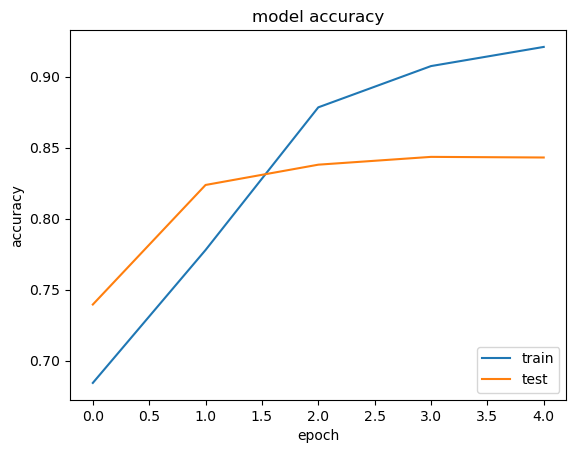

In [30]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [31]:
pre_Y_test = bidirect_model.predict(X_test)

69/69 [==============================] - 0s 4ms/step


In [32]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

69/69 [==============================] - 0s 4ms/step - loss: 0.4481 - acc: 0.8414
Loss: 0.4480702877044678,
Accuracy: 0.841406524181366


In [33]:
Y_test[0]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [34]:
pre_Y_test[0]

array([[9.30536259e-03, 6.70647100e-02, 1.58929616e-01, 7.64700294e-01],
       [1.02775775e-04, 9.94817436e-01, 6.40467624e-04, 4.43919608e-03],
       [2.53218197e-04, 9.84622836e-01, 1.15605062e-02, 3.56343784e-03],
       [2.53299891e-04, 7.92616785e-01, 1.56678453e-01, 5.04515283e-02],
       [1.28739790e-04, 9.86894906e-01, 7.23697338e-03, 5.73945325e-03],
       [1.59550880e-04, 9.90292430e-01, 8.01268313e-03, 1.53527502e-03],
       [4.79703158e-04, 9.75877345e-01, 2.18819417e-02, 1.76105683e-03]],
      dtype=float32)

In [35]:
pre = [] 
for i in range(0, pre_Y_test.shape[0]):
    pre.append(np.argmax(pre_Y_test[i], axis=1))

In [36]:
np.argmax(pre_Y_test[0], axis=1)

array([3, 1, 1, 1, 1, 1, 1], dtype=int64)

In [37]:
pre[:10]

[array([3, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 2], dtype=int64),
 array([1, 1, 1, 1, 1, 2, 3], dtype=int64),
 array([1, 1, 1, 1, 2, 3, 1], dtype=int64),
 array([3, 1, 1, 2, 3, 1, 2], dtype=int64),
 array([1, 1, 2, 3, 1, 2, 3], dtype=int64),
 array([1, 2, 3, 1, 2, 3, 3], dtype=int64),
 array([2, 3, 1, 2, 3, 3, 1], dtype=int64),
 array([3, 1, 2, 3, 1, 1, 1], dtype=int64),
 array([1, 2, 3, 1, 1, 1, 1], dtype=int64)]

In [38]:
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tag_tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [39]:
# Creating texts 
my_texts = list(map(sequence_to_text, pre))

In [40]:
labels = []
for i in range(1, len(my_texts)):
    labels.append(" ".join([str(i) for a,i in enumerate(my_texts[i])]))

In [41]:
evaluate  = pd.concat([test, pd.Series(labels)], axis=1) 

In [48]:
wrong = evaluate[evaluate["label"] !=  evaluate[0]].shape[0] 
correct = evaluate[evaluate["label"] ==  evaluate[0]].shape[0]

In [49]:
correct / (wrong + correct)

0.38803263825929285